# Simulate atmospheric transparency

In [28]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os,sys
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [29]:
from astropy.io import fits

In [30]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [31]:
os.getenv('LIBRADTRANDIR')

'/Users/dagoret/MacOSX/External/libRadtran2'

In [32]:
sys.path.append('../libradtran')

In [33]:
import libsimulateVisible

# Initialisation

In [34]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))



LA time: 07:46:45
NY time: 10:46:45
London time: 15:46:45
Paris time: 16:46:45


In [35]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [36]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""
   

In [37]:
msg = f"Start {parser.prog} at date : {string_date} and time :{current_time} and with arguments:{results_args}"
logger.info(msg)

2020-09-12 16:46:45,052 MacBook-Pro-de-admin.local __main__[15096] INFO Start ipykernel_launcher.py at date : 2020-09-12 and time :16:46:45 and with arguments:


# Configuration

In [38]:
# config file
# --------------
configfile = "config/default.ini"
packetnum =100
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)

2020-09-12 16:46:45,058 MacBook-Pro-de-admin.local __main__[15096] INFO Configuration file : config/default.ini


In [39]:
packet_str=str(packetnum).zfill(4)

In [40]:
packet_str

'0100'

In [41]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-12 16:46:45,076 MacBook-Pro-de-admin.local __main__[15096] INFO 1) Configuration


In [42]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)    

In [43]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
else:
    msg = f"empty section GENERAL in config file {config_filename} !"
    logger.error(msg)


if 'SIMTRANSPARENCY'in config_section:
    input_file = config['SIMTRANSPARENCY']['inputfile']
    input_dir = config['SIMTRANSPARENCY']['inputdir']

    output_file = config['SIMTRANSPARENCY']['outputfile']
    output_dir = config['SIMTRANSPARENCY']['outputdir']

    packetsize = int(config['SIMTRANSPARENCY']['packetsize'])

output_file_split=output_file.split(".")    
output_file=output_file_split[0]+"_"+packet_str+"."+output_file_split[1]    
    
full_inputfilename=os.path.join(input_dir,input_file)
full_outputfilename=os.path.join(output_dir,output_file)

In [44]:
msg = f"FLAG_PLOT = {FLAG_PLOT}"
logger.info(msg)

msg = f"FLAG_VERBOSE = {FLAG_VERBOSE}"
logger.info(msg)

msg=f"input file name = {full_inputfilename}"
logger.info(msg)

msg=f"output file name = {full_outputfilename}"
logger.info(msg)

# range inside the atmospheric parameter file
NROWMIN = (packetnum - 1) * packetsize
NROWMAX = (packetnum) * packetsize - 1

msg = f"NROWMIN = {NROWMIN} , NROWMAX  = {NROWMAX}  "
logger.info(msg)

2020-09-12 16:46:45,102 MacBook-Pro-de-admin.local __main__[15096] INFO FLAG_PLOT = True
2020-09-12 16:46:45,104 MacBook-Pro-de-admin.local __main__[15096] INFO FLAG_VERBOSE = False
2020-09-12 16:46:45,105 MacBook-Pro-de-admin.local __main__[15096] INFO input file name = atmsimdata/atmparam.fits
2020-09-12 16:46:45,106 MacBook-Pro-de-admin.local __main__[15096] INFO output file name = atmsimdata/atmtransparency_0100.fits
2020-09-12 16:46:45,108 MacBook-Pro-de-admin.local __main__[15096] INFO NROWMIN = 9900 , NROWMAX  = 9999  


# open input atmospheric parameters

In [45]:
hduin = fits.open(full_inputfilename)

In [46]:
msg = "{}".format(hduin.info())
logger.info(msg)

Filename: atmsimdata/atmparam.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   (6, 20000)   float64   


2020-09-12 16:46:45,125 MacBook-Pro-de-admin.local __main__[15096] INFO None


In [47]:
headerin=hduin[0].header
datain=hduin[0].data

In [48]:
NSIM=len(datain)

In [50]:
if NROWMIN>NSIM:
    msg = f" >>> NROWMIN = {NROWMIN} greater than  NSIM={NSIM} ==> stop simulation"
    logger.error(msg)

In [51]:
logger.info(headerin)

2020-09-12 16:46:45,178 MacBook-Pro-de-admin.local __main__[15096] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                    6                                                  NAXIS2  =                20000                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [52]:
logger.info(datain[0,:])

2020-09-12 16:46:45,195 MacBook-Pro-de-admin.local __main__[15096] INFO [  1.           1.16164483   0.18308412   6.31146578 133.31660654
   0.37547343]


In [53]:
hdr=headerin
NSIMH=hdr['NBATMSIM']
idx_num = hdr['ID_NUM']
idx_am = hdr['ID_AM']
idx_vaod=hdr['ID_VAOD']
idx_pwv= hdr['ID_PWV']
idx_o3=hdr['ID_O3']
idx_cld=hdr['ID_CLD']
idx_res= hdr['ID_RES']

# Simulate atmosphere with libradtran

In [54]:
all_wl=[]
all_transm=[]
all_z=[]

path,thefile=libsimulateVisible.ProcessSimulation(1,0,0,0,prof_str='us',proc_str='sa',cloudext=0)
data = np.loadtxt(os.path.join(path,thefile))
wl = data[:,0]
atm = data[:,1] 
NWL=len(wl)
dataout=np.zeros((packetsize+1,idx_res+NWL))
dataout[0,idx_res:]=wl
idx=0       
for irow in np.arange(min(NROWMIN,NSIM),min(NSIM,NROWMAX)+1):
   
    am=datain[irow,idx_am ]
    pwv=datain[irow,idx_pwv]
    ozone=datain[irow,idx_o3]
    aer=datain[irow,idx_vaod]
    pressure=0
    cloudext=datain[irow,idx_cld]
    msg=f"run libradtran : index={irow}, am={am:2.2f}, pwv={pwv:2.2f}, ozone={ozone:3.2f}, aer={aer:2.2f}"
    if FLAG_VERBOSE: 
        logger.info(msg)
    else:
        if idx%10 ==0:
            logger.info(msg)
            
    #path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
    path,thefile=libsimulateVisible.ProcessSimulationaer(am,pwv,ozone,aer,pressure,prof_str='us',proc_str='as',cloudext=0)

    data = np.loadtxt(os.path.join(path,thefile))
    wl = data[:,0]
    atm = data[:,1] 
    all_wl.append(wl)
    all_transm.append(atm)
    all_z.append(am)
         
        
    dataout[idx+1,idx_num]=irow
    dataout[idx+1,idx_am]=am
    dataout[idx+1,idx_vaod]=aer
    dataout[idx+1,idx_pwv]=pwv
    dataout[idx+1,idx_o3]=ozone
    dataout[idx+1,idx_cld]=cloudext
    dataout[idx+1,idx_res:]=atm
    
    idx+=1


2020-09-12 16:46:49,877 MacBook-Pro-de-admin.local __main__[15096] INFO run libradtran : index=9900, am=1.38, pwv=7.81, ozone=311.03, aer=0.18
2020-09-12 16:47:53,270 MacBook-Pro-de-admin.local __main__[15096] INFO run libradtran : index=9910, am=2.28, pwv=3.64, ozone=320.45, aer=0.13
2020-09-12 16:48:56,494 MacBook-Pro-de-admin.local __main__[15096] INFO run libradtran : index=9920, am=1.70, pwv=7.11, ozone=337.53, aer=0.42
2020-09-12 16:49:57,996 MacBook-Pro-de-admin.local __main__[15096] INFO run libradtran : index=9930, am=1.69, pwv=6.53, ozone=356.25, aer=0.25
2020-09-12 16:51:02,365 MacBook-Pro-de-admin.local __main__[15096] INFO run libradtran : index=9940, am=1.65, pwv=6.86, ozone=275.89, aer=0.36
2020-09-12 16:52:05,554 MacBook-Pro-de-admin.local __main__[15096] INFO run libradtran : index=9950, am=1.49, pwv=5.77, ozone=405.52, aer=0.84
2020-09-12 16:53:10,884 MacBook-Pro-de-admin.local __main__[15096] INFO run libradtran : index=9960, am=1.58, pwv=4.85, ozone=454.94, aer=0.52

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by z

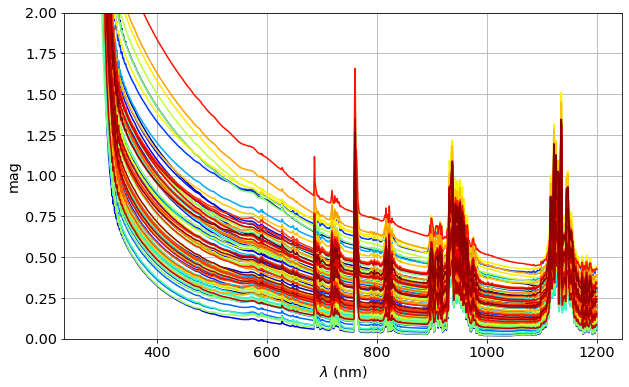

In [55]:
if FLAG_PLOT:
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=packetsize)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(packetsize), alpha=1)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    for index in np.arange(packetsize):
        am=all_z[index]
        label=f'z={am:2.2f}'
        ax.plot(all_wl[index],-2.5*np.log10(all_transm[index])/am,color=all_colors[index],label=label);
    if packetsize<=10:
        ax.legend()
    ax.set_ylim(0,2)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("mag")

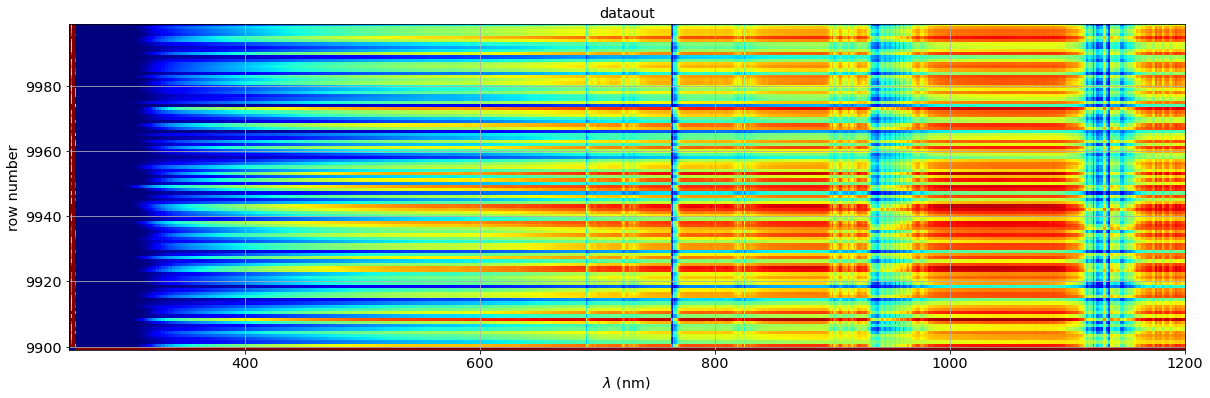

In [56]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(20,6))
    ax=fig.add_subplot(111)
    ax.imshow(dataout,origin="lower",aspect="auto",interpolation="nearest",vmin=0,vmax=1,cmap='jet',extent=[wl.min(),wl.max(),NROWMIN-1,NROWMAX])
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("row number")
    ax.set_title("dataout")

# save output file

In [57]:
msg=f"save in output file {full_outputfilename}"
logger.info(msg)

2020-09-12 16:57:36,961 MacBook-Pro-de-admin.local __main__[15096] INFO save in output file atmsimdata/atmtransparency_0100.fits


In [58]:
headerout=headerin

In [59]:
hdu = fits.PrimaryHDU(dataout,header=headerout)
hdu.writeto(full_outputfilename,overwrite=True)